----
### 0. Links and Code Library

- Guide to the Sequential model https://keras.io/getting-started/sequential-model-guide/
- Model evaluation: quantifying the quality of predictions http://scikit-learn.org/stable/modules/model_evaluation.html
- Extended version of this project https://olgabelitskaya.github.io/MLE_ND_P6_V0.html

In [1]:
import numpy as np 
import pandas as pd 
import scipy

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

macro.csv
sample_submission.csv
test.csv
train.csv



In [2]:
import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import KFold, ParameterGrid, cross_val_score
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

In [5]:
import keras as ks
from keras.models import Sequential, load_model, Model
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


----
### 1. Problem Statement

Sberbank is challenging programmers to develop algorithms which use a broad spectrum of features to predict real prices. Competitors will rely on a rich dataset that includes housing data and macroeconomic patterns. An accurate forecasting model will allow Sberbank to provide more certainty to their customers in an uncertain economy.

----
### 2. Datasets and Inputs

#### 2.1 Description by files

##### train.csv and test.csv

- price_doc: sale price (this is the target variable)
- id:transaction id
- timestamp: date of the transaction
- full_sq: total area in square meters, including loggias, balconies and other non-residential areas
- life_sq: living area in square meters, excluding loggias, balconies and other non-residential areas
- floor: for apartments, the floor of the building
- max_floor: number of floors in the building
- wall material
- year built
- number of living rooms
- kitch_sq: kitchen area
- state: apartment condition
- product_type: owner-occupier purchase or investment
- sub_area: name of the district

The dataset also includes a collection of features about each property's surrounding neighborhood and some features that are constant across each sub-area (known as a Raion). Most of the feature names are self-explanatory, with the following notes. See below for a complete list.

- full_all: subarea population
- male_f, female_f: subarea population by gender
- young_: population younger than working age
- work_: working-age population
- ekder_ : retirement-age population
- nm{all|male|female}: population between n and m years old
- buildcount: buildings in the subarea by construction type or year
- x_count_500: the number of x within 500m of the property
- x_part_500: the share of x within 500m of the property
- sqm: square meters
- cafe_count_d_price_p: number of cafes within d meters of the property that have an average bill under p RUB
- trc_: shopping malls
- prom_: industrial zones
- green_: green zones
- metro_: subway
- avto: distances by car
- mkad_: Moscow Circle Auto Road
- ttk_: Third Transport Ring
- sadovoe_: Garden Ring
- bulvarring: Boulevard Ring
- kremlin_: City Center
- zdvokzaly: Train station
- oilchemistry: Dirty industry
- ts_: Power plant

##### macro.csv

A set of macroeconomic indicators, one for each date.

- timestamp: Transaction timestamp
- oil_urals: Crude Oil Urals (usd/bbl)
- gdp_quart: GDP
- gdp_quart_growth: Real GDP growth
- cpi: Inflation - Consumer Price Index Growth
- ppi: Inflation - Producer Price index Growth
- gdp_deflator: Inflation - GDP deflator
- balance_trade: Trade surplus
- balance_trade_growth: Trade balance (as a percentage of previous year)
- usdrub: Ruble/USD exchange rate
- eurrub: Ruble/EUR exchange rate
- brent: London Brent (usd/bbl)
- net_capital_export: Net import / export of capital
- gdp_annual: GDP at current prices
- gdp_annual_growth: GDP growth (in real terms)
- average_provision_of_build_contract: Provision by orders in Russia (for the developer)
- average_provision_of_build_contract_moscow: Provision by orders in Moscow (for the developer)
- rts: Index RTS / return
- micex: MICEX index / return
- micex_rgbi_tr: MICEX index for government bonds (MICEX RGBI TR) / yield
- micex_cbi_tr: MICEX Index corporate bonds (MICEX CBI TR) / yield
- deposits_value: Volume of household deposits
- deposits_growth: Volume growth of population's deposits
- deposits_rate: Average interest rate on deposits
- mortgage_value: Volume of mortgage loans
- mortgage_growth: Growth of mortgage lending
- mortgage_rate: Weighted average rate of mortgage loans
- grp: GRP of the subject of Russian Federation where Apartment is located
- grp_growth: Growth of gross regional product of the subject of the Russian Federation where Apartment is located
- income_per_cap: Average income per capita
- real_dispos_income_per_cap_growth: Growth in real disposable income of Population
- salary: Average monthly salary
- salary_growth: Growth of nominal wages
- fixed_basket: Cost of a fixed basket of consumer goods and services for inter-regional comparisons of purchasing power
- retail_trade_turnover: Retail trade turnover
- retail_trade_turnover_per_cap: Retail trade turnover per capita
- retail_trade_turnover_growth: Retail turnover (in comparable prices in% to corresponding period of previous year)
- labor_force: Size of labor force
- unemployment: Unemployment rate
- employment: Employment rate
- invest_fixed_capital_per_cap: Investments in fixed capital per capita
- invest_fixed_assets: Absolute volume of investments in fixed assets
- profitable_enterpr_share: Share of profitable enterprises
- unprofitable_enterpr_share: The share of unprofitable enterprises
- share_own_revenues: The share of own revenues in the total consolidated budget revenues
- overdue_wages_per_cap: Overdue wages per person
- fin_res_per_cap: The financial results of companies per capita
- marriages_per_1000_cap: Number of marriages per 1,000 people
- divorce_rate: The divorce rate / growth rate
- construction_value: Volume of construction work performed (million rubles)
- invest_fixed_assets_phys: The index of physical volume of investment in fixed assets (in comparable prices in% to -
- the corresponding month of Previous year)
- pop_natural_increase: Rate of natural increase / decrease in Population (1,000 persons)
- pop_migration: Migration increase (decrease) of population
- pop_total_inc: Total population growth
- childbirth: Childbirth
- mortality: Mortality
- housing_fund_sqm: Housing Fund (sqm)
- lodging_sqm_per_cap: Lodging (sqm / pax)
- water_pipes_share: Plumbing availability (pax)
- baths_share: Bath availability (pax)
- sewerage_share: Canalization availability
- gas_share:Gas (mains, liquefied) availability
- hot_water_share: Hot water availability
- electric_stove_share: Electric heating for the floor
- heating_share: Heating availability
- old_house_share: Proportion of old and dilapidated housing, percent
- average_life_exp: Average life expectancy
- infant_mortarity_per_1000_cap: Infant mortality rate (per 1,000 children aged up to one year)
- perinatal_mort_per_1000_cap: Perinatal mortality rate (per 1,000 live births)
- incidence_population: Overall incidence of the total population
- rent_price_4+room_bus: rent price for 4-room apartment, business class
- rent_price_3room_bus: rent price for 3-room apartment, business class
- rent_price_2room_bus: rent price for 2-room apartment, business class
- rent_price_1room_bus: rent price for 1-room apartment, business class
- rent_price_3room_eco: rent price for 3-room apartment, econom class
- rent_price_2room_eco: rent price for 2-room apartment, econom class
- rent_price_1room_eco: rent price for 1-room apartment, econom class
- load_of_teachers_preschool_per_teacher: Load of teachers of preschool educational institutions (number of children per 100 teachers)
- child_on_acc_pre_school: Number of children waiting for the determination to pre-school educational institutions, for capacity of 100
- load_of_teachers_school_per_teacher: Load on teachers in high school (number of pupils in hugh school for 100 teachers)
- students_state_oneshift: Proportion of pupils in high schools with one shift, of the total number of pupils in high schools
- modern_education_share: Share of state (municipal) educational organizations, corresponding to modern requirements of education in the total number of high schools
- old_education_build_share: The share of state (municipal) educational organizations, buildings are in disrepair and in need of major repairs of the total number
- provision_doctors: Provision (relative number) of medical doctors in area
- provision_nurse: Provision of nursing staff
- load_on_doctors: The load on doctors (number of visits per physician)
- power_clinics: Capacity of outpatient clinics
- hospital_beds_available_per_cap: Availability of hospital beds per 100 000 persons
- hospital_bed_occupancy_per_year: Average occupancy rate of the hospital beds during a year
- provision_retail_space_sqm: Retail space
- provision_retail_space_modern_sqm: Provision of population with retail space of modern formats, square meter
- retail_trade_turnover_per_cap: Retail trade turnover per capita
- turnover_catering_per_cap: Turnover of catering industry per person
- theaters_viewers_per_1000_cap: Number of theaters viewers per 1000 population
- seats_theather_rfmin_per_100000_cap: Total number of seats in Auditorium of the Ministry of Culture Russian theaters per 100,000 population
- museum_visitis_per_100_cap: Number of visits to museums per 1000 of population
- bandwidth_sports: Capacity of sports facilities
- population_reg_sports_share: Proportion of population regularly doing sports
- students_reg_sports_share: Proportion of pupils and students regularly doing sports in the total number
- apartment_build: City residential apartment construction
- apartment_fund_sqm: City residential apartment fund

#### 2.2 Data Loading and Displaying

In [6]:
macro = pd.read_csv('../input/macro.csv')
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [7]:
macro[100:103].T[1:15]

,100,101,102
oil_urals,82.87,82.87,82.87
gdp_quart,9995.8,9995.8,9995.8
gdp_quart_growth,4.1,4.1,4.1
cpi,319.8,319.8,319.8
ppi,350.2,350.2,350.2
gdp_deflator,NaN,NaN,NaN
balance_trade,16.604,16.604,16.604
balance_trade_growth,14.1,14.1,14.1
usdrub,29.1525,29.0261,29.1
eurrub,39.2564,39.4051,39.5008


In [ ]:
train[200:203].T[1:15]

,200,201,202
timestamp,2011-10-25,2011-10-25,2011-10-25
full_sq,38,33,30
life_sq,19,14,18
floor,15,8,3
max_floor,NaN,NaN,NaN
material,NaN,NaN,NaN
build_year,NaN,NaN,NaN
num_room,NaN,NaN,NaN
kitch_sq,NaN,NaN,NaN
state,NaN,NaN,NaN


----
### 3. Solution Statement

#### 3.1 Selection of features

In [8]:
X_list_num = ['full_sq', 'num_room', 'floor', 'timestamp',
              'preschool_education_centers_raion', 'school_education_centers_raion', 
              'children_preschool', 'children_school',
              'shopping_centers_raion', 'healthcare_centers_raion', 
              'office_raion', 'sport_objects_raion',
              'metro_min_walk', 'public_transport_station_min_walk', 
              'railroad_station_walk_min', 'cafe_count_500',
              'kremlin_km', 'workplaces_km', 'ID_metro',
              'public_healthcare_km', 'kindergarten_km', 'school_km', 'university_km', 
              'museum_km', 'fitness_km', 'park_km', 'shopping_centers_km',
              'additional_education_km', 'theater_km', 
              'raion_popul', 'work_all', 'young_all', 'ekder_all']
X_list_cat = ['sub_area', 'ecology', 'big_market_raion']

features_train = train[X_list_num]
features_test = test[X_list_num]
target_train = train['price_doc']

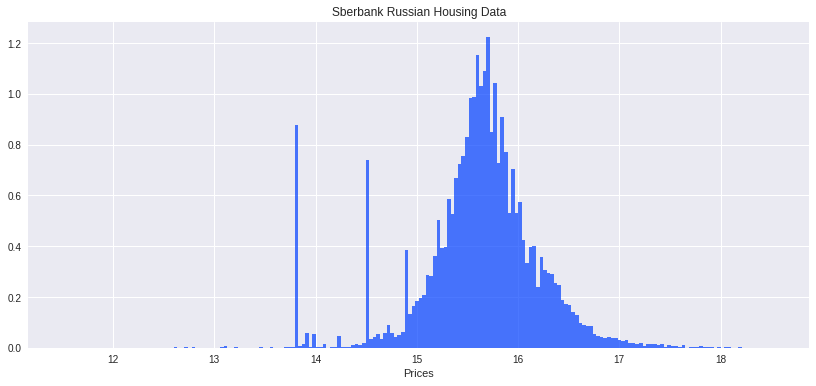

In [9]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(14, 6))

plt.hist(np.log(target_train), bins=200, normed=True, alpha=0.7)

plt.xlabel("Prices")
plt.title('Sberbank Russian Housing Data');

In [10]:
print ("Sberbank Russian Housing Dataset Statistics: \n")
print ("Number of houses = ", len(target_train))
print ("Number of features = ", len(list(features_train.keys())))
print ("Minimum house price = ", np.min(target_train))
print ("Maximum house price = ", np.max(target_train))
print ("Mean house price = ", "%.2f" % np.mean(target_train))
print ("Median house price = ", "%.2f" % np.median(target_train))
print ("Standard deviation of house prices =", "%.2f" % np.std(target_train))

Sberbank Russian Housing Dataset Statistics: 

Number of houses =  30471
Number of features =  33
Minimum house price =  100000
Maximum house price =  111111112
Mean house price =  7123035.28
Median house price =  6274411.00
Standard deviation of house prices = 4780032.89


#### 3.2 Fill in missing values

In [11]:
features_train.isnull().sum()

full_sq                                 0
num_room                             9572
floor                                 167
timestamp                               0
preschool_education_centers_raion       0
school_education_centers_raion          0
children_preschool                      0
children_school                         0
shopping_centers_raion                  0
healthcare_centers_raion                0
office_raion                            0
sport_objects_raion                     0
metro_min_walk                         25
public_transport_station_min_walk       0
railroad_station_walk_min              25
cafe_count_500                          0
kremlin_km                              0
workplaces_km                           0
ID_metro                                0
public_healthcare_km                    0
kindergarten_km                         0
school_km                               0
university_km                           0
museum_km                         

In [12]:
features_test.isnull().sum()

full_sq                               0
num_room                              0
floor                                 0
timestamp                             0
preschool_education_centers_raion     0
school_education_centers_raion        0
children_preschool                    0
children_school                       0
shopping_centers_raion                0
healthcare_centers_raion              0
office_raion                          0
sport_objects_raion                   0
metro_min_walk                       34
public_transport_station_min_walk     0
railroad_station_walk_min            34
cafe_count_500                        0
kremlin_km                            0
workplaces_km                         0
ID_metro                              0
public_healthcare_km                  0
kindergarten_km                       0
school_km                             0
university_km                         0
museum_km                             0
fitness_km                            0


In [13]:
df = pd.DataFrame(features_train, columns=X_list_num)
df['prices'] = target_train

df = df.dropna(subset=['num_room'])

df['metro_min_walk'] = df['metro_min_walk'].interpolate(method='quadratic')
features_test['metro_min_walk'] = features_test['metro_min_walk'].interpolate(method='quadratic')

df['railroad_station_walk_min'] = df['railroad_station_walk_min'].interpolate(method='quadratic')
features_test['railroad_station_walk_min'] = \
features_test['railroad_station_walk_min'].interpolate(method='quadratic')

df['floor'] = df['floor'].fillna(df['floor'].median())
len(df)

20899

#### 3.3 Categorical and macro features

In [14]:
ID_metro_cat = pd.factorize(df['ID_metro'])
df['ID_metro'] = ID_metro_cat[0]

In [15]:
ID_metro_pairs = dict(zip(list(ID_metro_cat[1]), list(set(ID_metro_cat[0]))))
ID_metro_pairs[224] = 219
features_test['ID_metro'].replace(ID_metro_pairs,inplace=True)

In [16]:
usdrub_pairs = dict(zip(list(macro['timestamp']), list(macro['usdrub'])))

In [17]:
df['timestamp'].replace(usdrub_pairs,inplace=True)
features_test['timestamp'].replace(usdrub_pairs,inplace=True)

In [18]:
df.rename(columns={'timestamp' : 'usdrub'}, inplace=True)
features_test.rename(columns={'timestamp' : 'usdrub'}, inplace=True)

#### 3.4 Displaying correlation

In [19]:
pearson = df.corr(method='pearson')
corr_with_prices = pearson.ix[-1][:-1]
corr_with_prices[abs(corr_with_prices).argsort()[::-1]]

full_sq                              0.593829
num_room                             0.476337
kremlin_km                          -0.290126
sport_objects_raion                  0.256412
ID_metro                             0.250502
university_km                       -0.222964
theater_km                          -0.222873
workplaces_km                       -0.220889
museum_km                           -0.203846
park_km                             -0.201636
metro_min_walk                      -0.200031
fitness_km                          -0.197702
school_education_centers_raion       0.193896
healthcare_centers_raion             0.185419
shopping_centers_km                 -0.182459
public_healthcare_km                -0.182388
ekder_all                            0.169331
school_km                           -0.158775
preschool_education_centers_raion    0.157762
office_raion                         0.149137
additional_education_km             -0.146074
raion_popul                       

#### 3.5 Scale, Shuffle and Split the Data

In [20]:
target_train = df['prices'].as_matrix()
features_train = df.drop('prices', 1).as_matrix()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features_train, target_train, 
                                                    test_size = 0.2, random_state = 1)
X_train.shape, X_test.shape

((16719, 33), (4180, 33))

In [22]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

### 4. Benchmark Models

#### 4.1 Regressors

In [23]:
def regression(regressor, x_train, x_test, y_train):
    reg = regressor
    reg.fit(x_train, y_train)
    
    y_train_reg = reg.predict(x_train)
    y_test_reg = reg.predict(x_test)
    
    return y_train_reg, y_test_reg

In [24]:
y_train_gbr, y_test_gbr = regression(GradientBoostingRegressor(n_estimators=100, 
                                                               max_depth=3, 
                                                               learning_rate=.1, 
                                                               min_samples_leaf=5, 
                                                               min_samples_split=5), 
                                     X_train, X_test, y_train)

y_train_br, y_test_br = regression(BaggingRegressor(n_estimators=100), 
                                   X_train, X_test, y_train)

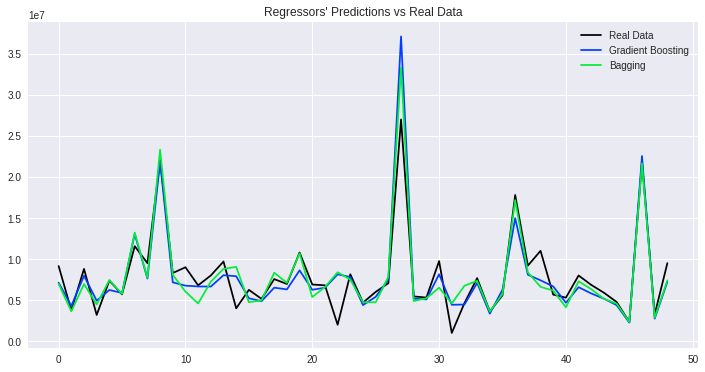

In [25]:
plt.figure(figsize = (12,6))

plt.plot(y_test[1:50], color = 'black', label='Real Data')

plt.plot(y_test_gbr[1:50], label='Gradient Boosting')
plt.plot(y_test_br[1:50], label='Bagging')

plt.legend()
plt.title("Regressors' Predictions vs Real Data"); 

#### 4.2 Neural Networks

In [26]:
def loss_plot(fit_history):
    plt.figure(figsize=(14, 6))

    plt.plot(fit_history.history['loss'], label = 'train')
    plt.plot(fit_history.history['val_loss'], label = 'test')

    plt.legend()
    plt.title('Loss Function');  
    
def mae_plot(fit_history):
    plt.figure(figsize=(14, 6))

    plt.plot(fit_history.history['mean_absolute_error'], label = 'train')
    plt.plot(fit_history.history['val_mean_absolute_error'], label = 'test')

    plt.legend()
    plt.title('Mean Absolute Error'); 

In [27]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(128, input_dim=33, kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu')) 
    
#    model.add(Dropout(0.1))
    
#    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
#    model.add(Dense(16, kernel_initializer='normal', activation='relu')) 
    
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

In [28]:
mlp_model = mlp_model()

mlp_history = mlp_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            nb_epoch=80, batch_size=16, verbose=0)

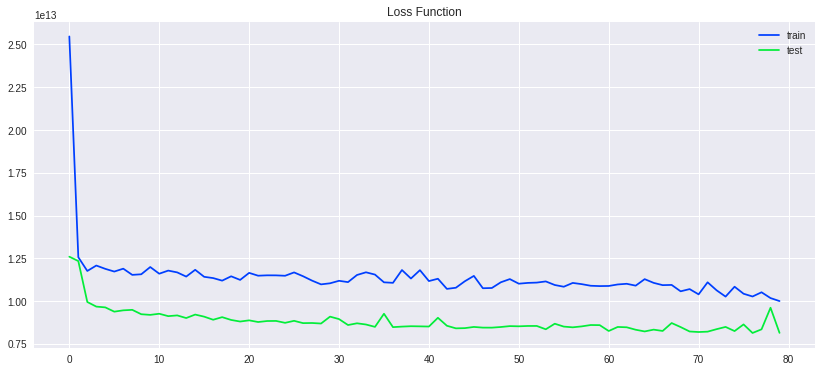

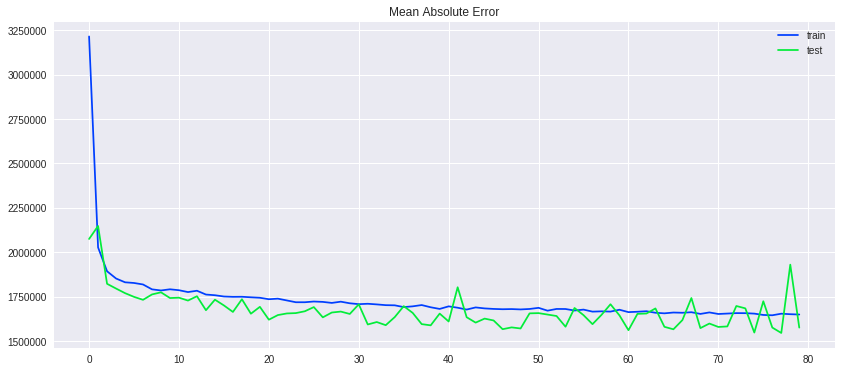

In [29]:
loss_plot(mlp_history)
mae_plot(mlp_history)

In [30]:
y_train_mlp = mlp_model.predict(X_train)
y_test_mlp = mlp_model.predict(X_test)

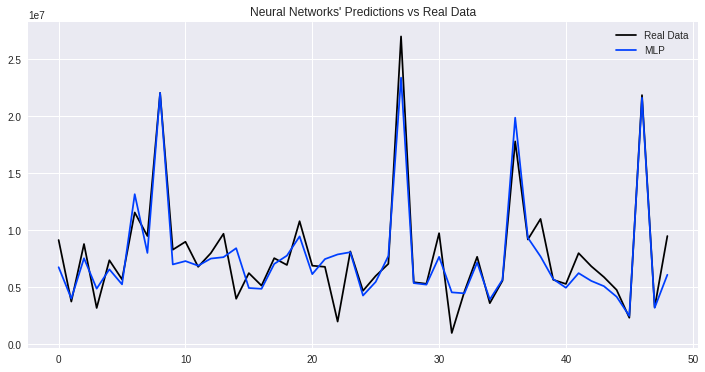

In [31]:
plt.figure(figsize = (12,6))

plt.plot(y_test[1:50], color = 'black', label='Real Data')

plt.plot(y_test_mlp[1:50], label='MLP')
# plt.plot(y_test_br[1:50], label='CNN')

plt.legend()
plt.title("Neural Networks' Predictions vs Real Data"); 

----
### 5. Evaluation Metrics
- explained variance regression score
- coefficient of determination
- mean squared error
- mean absolute error
- median absolute error

In [32]:
def scores(regressor, y_train, y_test, y_train_reg, y_test_reg):
    print("_______________________________________")
    print(regressor)
    print("_______________________________________")
    print("EV score. Train: ", explained_variance_score(y_train, y_train_reg))
    print("EV score. Test: ", explained_variance_score(y_test, y_test_reg))
    print("---------")
    print("R2 score. Train: ", r2_score(y_train, y_train_reg))
    print("R2 score. Test: ", r2_score(y_test, y_test_reg))
    print("---------")
    print("MSE score. Train: ", mean_squared_error(y_train, y_train_reg))
    print("MSE score. Test: ", mean_squared_error(y_test, y_test_reg))
    print("---------")
    print("MAE score. Train: ", mean_absolute_error(y_train, y_train_reg))
    print("MAE score. Test: ", mean_absolute_error(y_test, y_test_reg))
    print("---------")
    print("MdAE score. Train: ", median_absolute_error(y_train, y_train_reg))
    print("MdAE score. Test: ", median_absolute_error(y_test, y_test_reg))

#### 5.1 Regressors

In [33]:
scores('Gradient Boosting Regressor', y_train, y_test, y_train_gbr, y_test_gbr)
scores('Bagging Regressor', y_train, y_test, y_train_br, y_test_br)

_______________________________________
Gradient Boosting Regressor
_______________________________________
EV score. Train:  0.743222313033
EV score. Test:  0.685978033193
---------
R2 score. Train:  0.743222313033
R2 score. Test:  0.685779622318
---------
MSE score. Train:  6.05193966277e+12
MSE score. Test:  8.14827307928e+12
---------
MAE score. Train:  1455209.36631
MAE score. Test:  1587710.42847
---------
MdAE score. Train:  751098.219602
MdAE score. Test:  839162.443108
_______________________________________
Bagging Regressor
_______________________________________
EV score. Train:  0.95620730173
EV score. Test:  0.704784351531
---------
R2 score. Train:  0.956178934778
R2 score. Test:  0.704647528644
---------
MSE score. Train:  1.03280953192e+12
MSE score. Test:  7.65899592191e+12
---------
MAE score. Train:  530929.013252
MAE score. Test:  1474362.44802
---------
MdAE score. Train:  228625.6
MdAE score. Test:  706177.51


#### 5.2 Neural Networks

In [34]:
scores('MLP Model', y_train, y_test, y_train_mlp, y_test_mlp)

_______________________________________
MLP Model
_______________________________________
EV score. Train:  0.580447282988
EV score. Test:  0.685875732034
---------
R2 score. Train:  0.580446147038
R2 score. Test:  0.6858672552
---------
MSE score. Train:  9.88837711488e+12
MSE score. Test:  8.14600060841e+12
---------
MAE score. Train:  1537378.08958
MAE score. Test:  1576380.91077
---------
MdAE score. Train:  770835.0
MdAE score. Test:  835216.25


----
### 6. Predictions

In [35]:
scale = StandardScaler()
features_train = scale.fit_transform(features_train)
features_test = scale.fit_transform(features_test.as_matrix())

In [36]:
reg = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=.1, 
                                min_samples_leaf=5, min_samples_split=5)
reg.fit(features_train, target_train)

target_train_predict = reg.predict(features_train)
target_test_predict = reg.predict(features_test)

In [37]:
print("_______________________________________")
print("Gradient Boosting  Regressor")
print("_______________________________________")
print("EV score. Train: ", explained_variance_score(target_train, target_train_predict))
print("---------")
print("R2 score. Train: ", r2_score(target_train, target_train_predict))
print("---------")
print("MSE score. Train: ", mean_squared_error(target_train, target_train_predict))
print("---------")
print("MAE score. Train: ", mean_absolute_error(target_train, target_train_predict))
print("---------")
print("MdAE score. Train: ", median_absolute_error(target_train, target_train_predict))

_______________________________________
Gradient Boosting  Regressor
_______________________________________
EV score. Train:  0.819832435025
---------
R2 score. Train:  0.819832435025
---------
MSE score. Train:  4.33156947739e+12
---------
MAE score. Train:  1256230.44238
---------
MdAE score. Train:  656215.937017


----
### 7. Submission

In [38]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
target_predict = ["{0:.2f}".format(x) for x in target_test_predict]

submission = pd.DataFrame({"id": test['id'], "price_doc": target_predict})
print(submission[0:5])

# submission.to_csv('kaggle_sberbank_housing.csv', index=False)


      id   price_doc
0  30474  4921023.11
1  30475  8067384.81
2  30476  5711600.07
3  30477  5633881.24
4  30478  4889491.77
